In [1]:
import os
import pandas as pd

data_path = 'ml-1m/'
movies_filename = 'movies.dat'
ratings_filename = 'ratings.dat'

In [ ]:
# UserID::Gender::Age::Occupation::Zip-code
# user_col = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
# users_df = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.user', sep='|', names=user_columns)

# Cleaning

In [15]:
movie_col = ['movieId','title','genre']
# movie_df = pd.read_csv(os.path.join(data_path , movies_filename), sep='::',names=movie_col)
df_movies = pd.read_csv('./ml-1m/movies.dat', sep='::',names=movie_col,encoding='latin-1',engine='python',usecols=['movieId','title'])

df_movies

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
3878,3948,Meet the Parents (2000)
3879,3949,Requiem for a Dream (2000)
3880,3950,Tigerland (2000)
3881,3951,Two Family House (2000)


In [17]:
ratings_col = ['userId','movieId','rating','timestamps']
df_ratings = pd.read_csv('./ml-1m/ratings.dat',sep='::',names=ratings_col,encoding='latin-1',engine='python',usecols=['userId', 'movieId', 'rating'])
df_ratings

,userId,movieId,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [18]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
df_movie_features = df_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

In [19]:
mat_movie_features = csr_matrix(df_movie_features.values)

In [20]:
df_movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movieId,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Finding and Removing Redundant data

In [21]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [22]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 6040 unique users and 3706 unique movies in this data set


In [23]:
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
1,56174
2,107557
3,261197
4,348971
5,226310


In [24]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,21384031
1.0,56174
2.0,107557
3.0,261197
4.0,348971
5.0,226310


In [25]:
#log normalise to make it easier to interpret on a graph
import numpy as np
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,21384031,16.878155
1.0,56174,10.936209
2.0,107557,11.585776
3.0,261197,12.473030
4.0,348971,12.762744
5.0,226310,12.329661


Matplotlib is building the font cache; this may take a moment.


Text(0, 0.5, 'number of ratings')

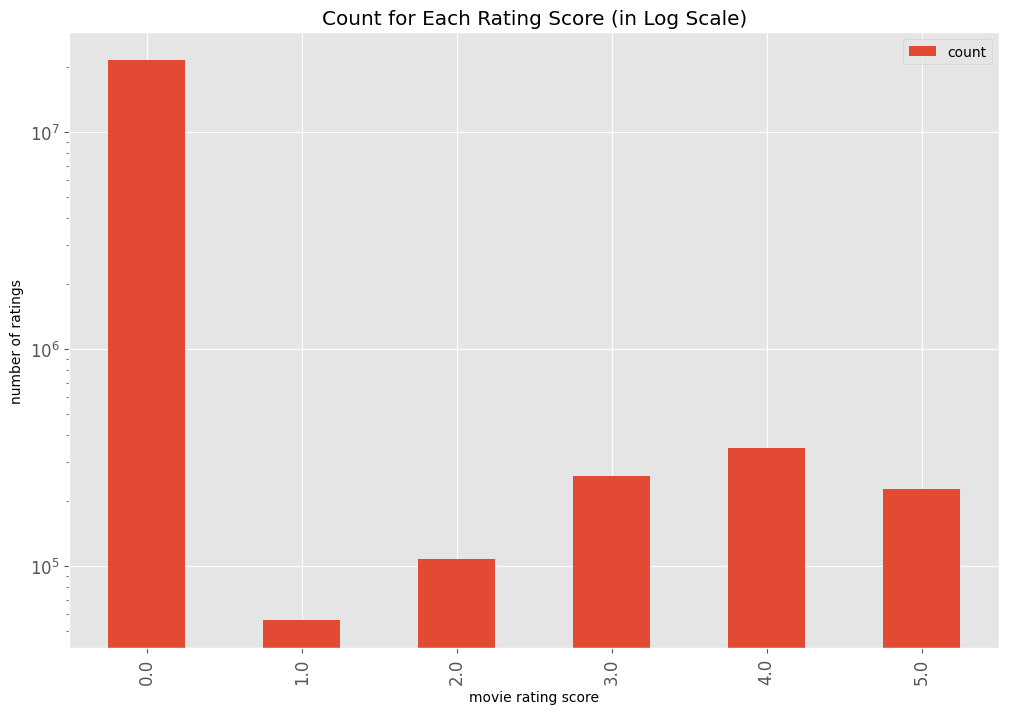

In [27]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [28]:
# get rating frequency
#number of ratings each movie got.
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,2077
2,701
3,478
4,170
5,296


In [29]:
#now we need to take only movies that have been rated atleast 50 times to get some idea of the reactions of users towards it

popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (1000209, 3)
shape of ratings data after dropping unpopular movies:  (977839, 3)


In [30]:
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,53
2,128
3,51
4,21
5,192


In [31]:
# filter data to come to an approximation of user likings.
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (1000209, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (920334, 3)


In [32]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
#map movie titles to images
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [33]:
movie_user_mat_sparse

<2514x4259 sparse matrix of type '<class 'numpy.float64'>'
	with 920334 stored elements in Compressed Sparse Row format>

# Starting CF Recommendation using KNN

In [34]:
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [36]:
from fuzzywuzzy import fuzz

/home/ameya/.local/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [39]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. 
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [40]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [42]:
my_favorite = 'Iron Man (2008)'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Iron Man (2008)
Found possible matches in our database: ['Hollow Man (2000)', 'Drowning Mona (2000)', 'Repo Man (1984)', 'Rain Man (1988)', 'Tigerland (2000)', 'Mission to Mars (2000)', 'Here on Earth (2000)', 'Urbania (2000)', 'Iron Eagle (1986)', 'Tin Men (1987)', 'Bring It On (2000)', 'Chicken Run (2000)', 'Beyond the Mat (2000)', 'Boiler Room (2000)', 'Dinosaur (2000)', 'Snow Day (2000)', 'Soul Man (1986)', 'Holy Man (1998)']

Recommendation system start to make inference
......

Recommendations for Iron Man (2008):
1: Mission: Impossible 2 (2000), with distance of 0.6685596124529134
2: Gone in 60 Seconds (2000), with distance of 0.6668419475736449
3: Me, Myself and Irene (2000), with distance of 0.6636422457651181
4: Scream 3 (2000), with distance of 0.6604671587294828
5: Final Destination (2000), with distance of 0.6558414666681434
6: X-Men (2000), with distance of 0.649339538512721
7: What Lies Beneath (2000), with distance of 0.6490238438959085
8: Perfect 